In [ ]:
# Cell 1: Load Results and Data
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

# Load model results
with open(os.path.join('..', 'models', 'model_results.pkl'), 'rb') as f:
    results = pickle.load(f)

feature_columns = results['feature_columns']
metrics = results['metrics']
target_col = results.get('target_column', 'target_return')
split_info = results.get('split_info', {})
best_params = results.get('best_params', {})
predictions = results.get('predictions', {})

# Load dataset
dataset = pd.read_csv(os.path.join('..', 'data', 'processed_dataset.csv'))
dataset['date'] = pd.to_datetime(dataset['date'])

# Use saved predictions from Colab (avoids XGBoost version mismatch)
if predictions:
    y_train = np.array(predictions['y_train'])
    y_test = np.array(predictions['y_test'])
    y_pred_train = np.array(predictions['y_pred_train'])
    y_pred_test = np.array(predictions['y_pred_test'])
    test_tickers = predictions.get('test_tickers', [])
    test_dates = predictions.get('test_dates', [])
    test_raw_returns = np.array(predictions.get('test_raw_returns', []))
    print("Loaded saved predictions from Colab")
else:
    print("WARNING: No saved predictions found - metrics display only")

print(f"\n=== Model Results Loaded ===")
print(f"Dataset: {len(dataset)} samples, {dataset['ticker'].nunique()} companies")
print(f"Features: {len(feature_columns)}")
print(f"Target: {target_col}")
print(f"\nMetrics:")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")
if split_info:
    print(f"\nSplit: {split_info.get('method', 'unknown')}, cutoff={split_info.get('cutoff_date', 'N/A')}")
    print(f"  Train: {split_info.get('train_size', 'N/A')}, Test: {split_info.get('test_size', 'N/A')}, CV folds: {split_info.get('cv_folds', 'N/A')}")
if best_params:
    print(f"\nBest hyperparameters:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")

In [ ]:
# Cell 2: Model Performance Summary (using saved predictions from Colab)

direction_correct = np.sum(np.sign(y_test) == np.sign(y_pred_test))
direction_accuracy = direction_correct / len(y_test)

print("="*55)
print("    STOCK RETURN PREDICTION - MODEL PERFORMANCE")
print("="*55)
print(f"\nDataset: {len(dataset)} company-quarter samples")
print(f"Companies: {dataset['ticker'].nunique()}")
print(f"Features: {len(feature_columns)} (after selection)")
print(f"Target: {target_col}")
print(f"\nTemporal split (cutoff: {split_info.get('cutoff_date', 'N/A')}):")
print(f"  Train: {split_info.get('train_size', len(y_train))} samples | Test: {split_info.get('test_size', len(y_test))} samples")
print(f"\n--- Regression Metrics ---")
print(f"Train RMSE: {metrics['train_rmse']:.4f}")
print(f"Test RMSE:  {metrics['test_rmse']:.4f}")
print(f"Train R2:   {metrics['train_r2']:.4f}")
print(f"Test R2:    {metrics['test_r2']:.4f}")
print(f"Test MAE:   {metrics.get('test_mae', 0):.4f}")
print(f"Overfit ratio: {metrics.get('overfit_ratio', 0):.2f}")
print(f"\n--- Time-Series Cross-Validation ---")
print(f"CV RMSE:    {metrics.get('cv_rmse_mean', 0):.4f} (+/- {metrics.get('cv_rmse_std', 0):.4f})")
print(f"\n--- Direction Accuracy ---")
print(f"Correct direction: {direction_correct}/{len(y_test)} ({direction_accuracy:.1%})")
print(f"(Baseline random: 50%)")

In [ ]:
# Cell 3: Feature Importance Analysis
model = results.get('model')
if model is not None:
    try:
        importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
    except Exception:
        # Fallback: equal importance if model can't be loaded
        importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': [1.0 / len(feature_columns)] * len(feature_columns)
        })
        print("Note: Could not extract feature importances (XGBoost version mismatch)")
else:
    importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': [1.0 / len(feature_columns)] * len(feature_columns)
    })

print("Feature Importance Ranking:")
print("-" * 40)
for _, row in importance.iterrows():
    bar = '#' * int(row['importance'] * 50)
    print(f"{row['feature']:25s} {row['importance']:.3f} {bar}")

# Show top features in chart
top_n = min(15, len(importance))
top_features = importance.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(top_features['feature'][::-1], top_features['importance'][::-1], color='steelblue')
ax.set_xlabel('Importance Score')
ax.set_title(f'XGBoost Feature Importance (Top {top_n} of {len(feature_columns)})')
plt.tight_layout()
plt.savefig(os.path.join('..', 'results', 'feature_importance_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Cell 4: Prediction Analysis (using saved predictions from Colab)
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# 1. Predicted vs Actual
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5, edgecolor='black', s=40)
lims = [min(y_test.min(), y_pred_test.min()) - 0.05, max(y_test.max(), y_pred_test.max()) + 0.05]
axes[0, 0].plot(lims, lims, 'r--', label='Perfect prediction')
axes[0, 0].set_xlabel(f'Actual {target_col}')
axes[0, 0].set_ylabel(f'Predicted {target_col}')
axes[0, 0].set_title('Predicted vs Actual (Test Set)')
axes[0, 0].legend()

# 2. Residuals
residuals = y_test - y_pred_test
axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Prediction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Prediction Errors')

# 3. Average return by company
company_returns = dataset.groupby('ticker')['target_return'].mean().sort_values()
colors = ['salmon' if v < 0 else 'steelblue' for v in company_returns.values]
axes[1, 0].barh(company_returns.index, company_returns.values, color=colors)
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Average Quarterly Return')
axes[1, 0].set_title(f'Average Return by Company ({dataset["ticker"].nunique()} companies)')
axes[1, 0].tick_params(axis='y', labelsize=7)

# 4. Cumulative returns (model strategy vs buy & hold)
if len(test_raw_returns) > 0:
    strategy_returns = np.where(y_pred_test > 0, test_raw_returns, 0)
    buy_hold = np.cumprod(1 + test_raw_returns) - 1
    strategy = np.cumprod(1 + strategy_returns) - 1
    axes[1, 1].plot(range(len(buy_hold)), buy_hold, label='Buy & Hold', alpha=0.7)
    axes[1, 1].plot(range(len(strategy)), strategy, label='Model Strategy', alpha=0.7)
    axes[1, 1].set_xlabel('Test Sample')
    axes[1, 1].set_ylabel('Cumulative Return')
    axes[1, 1].set_title('Cumulative Returns: Model vs Buy & Hold')
    axes[1, 1].legend()
    axes[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
else:
    # Fallback: feature correlations
    corr = dataset[feature_columns + ['target_return']].corr()['target_return'].drop('target_return').sort_values()
    top_corr = pd.concat([corr.head(8), corr.tail(8)]).drop_duplicates()
    corr_colors = ['salmon' if v < 0 else 'steelblue' for v in top_corr.values]
    axes[1, 1].barh(top_corr.index, top_corr.values, color=corr_colors)
    axes[1, 1].set_xlabel('Correlation with Target')
    axes[1, 1].set_title('Feature Correlations')

plt.tight_layout()
plt.savefig(os.path.join('..', 'results', 'prediction_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

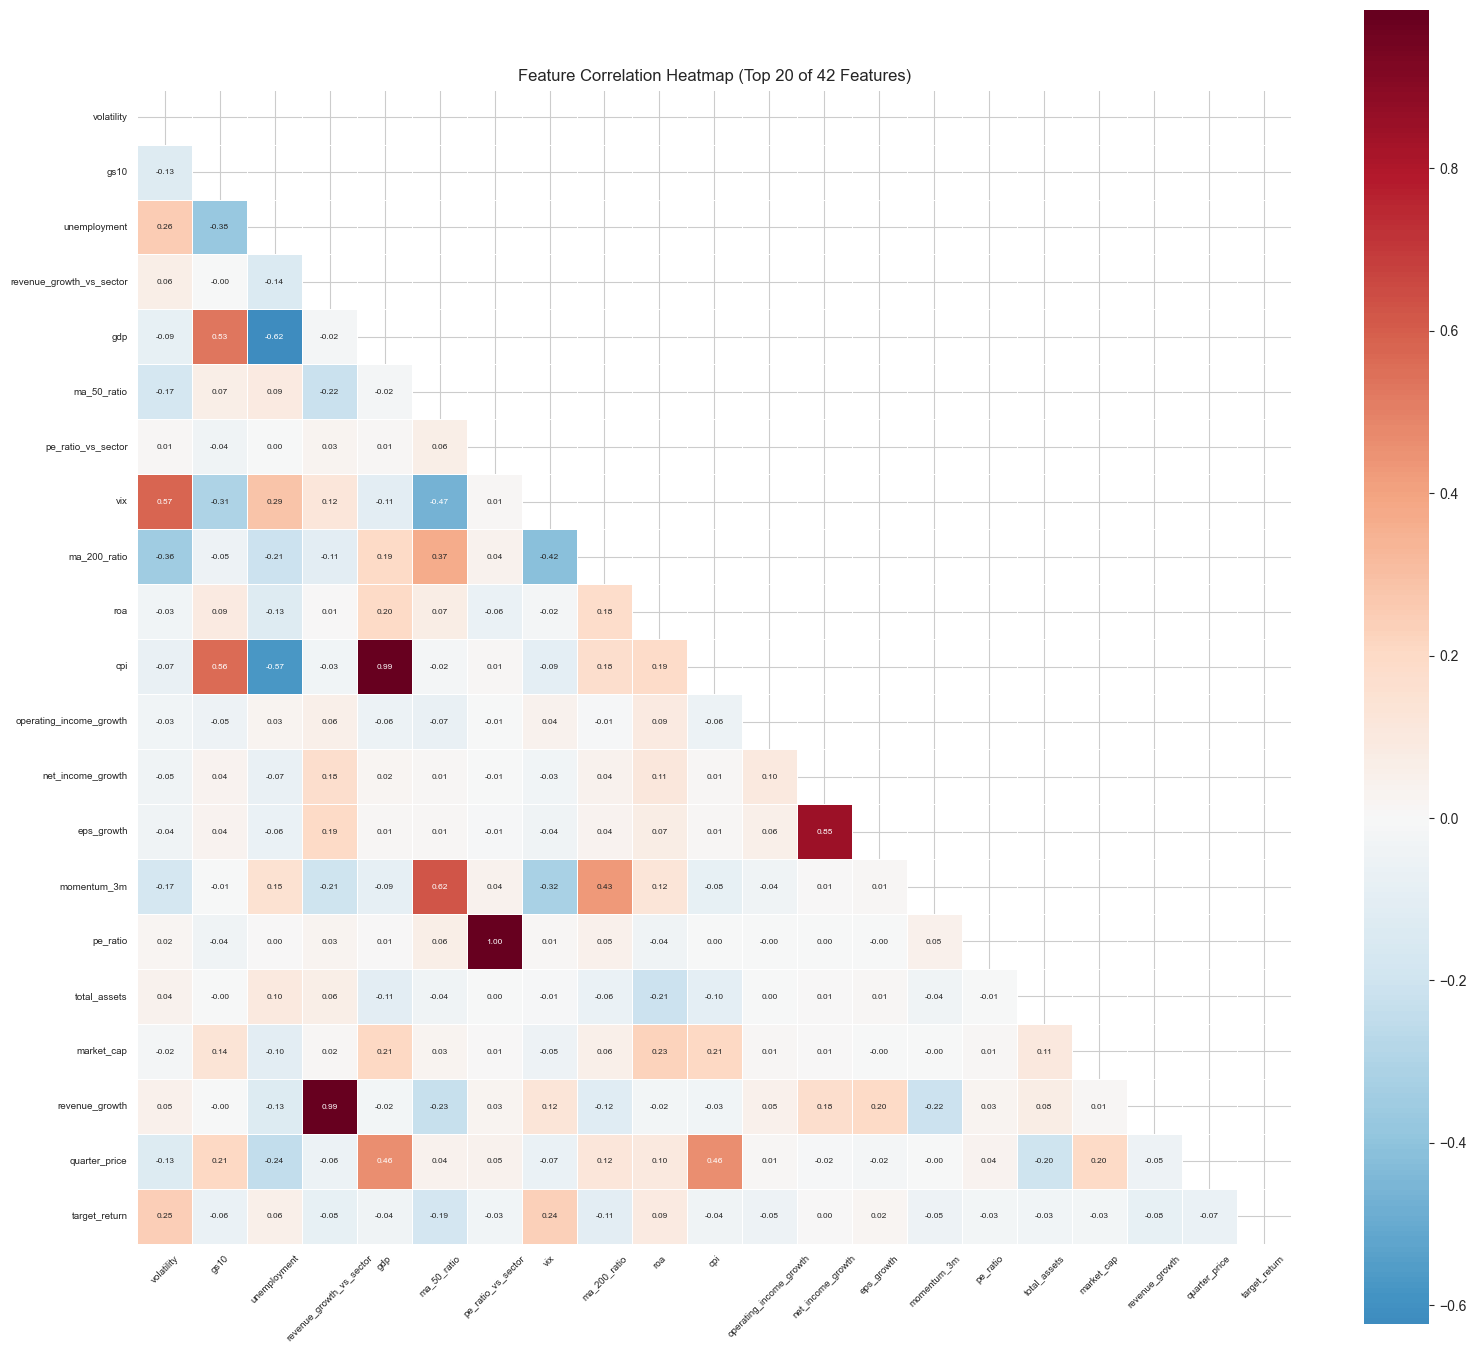

In [5]:
# Cell 5: Correlation Heatmap (top features only for readability)
# With 42 features, full heatmap is too dense - show top 20 most important
top_20 = importance.head(20)['feature'].tolist()
heatmap_cols = top_20 + ['target_return']

fig, ax = plt.subplots(figsize=(16, 14))
corr_matrix = dataset[heatmap_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt='.2f',
    cmap='RdBu_r', center=0, square=True,
    linewidths=0.5, ax=ax, annot_kws={'size': 6}
)
ax.set_title(f'Feature Correlation Heatmap (Top 20 of {len(feature_columns)} Features)')
ax.tick_params(axis='x', labelsize=7, rotation=45)
ax.tick_params(axis='y', labelsize=7)
plt.tight_layout()
plt.savefig(os.path.join('..', 'results', 'correlation_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Cell 6: Final Summary
print("="*55)
print("    PROJECT SUMMARY")
print("="*55)

target_label = "excess returns (vs S&P 500)" if target_col == 'target_excess_return' else "raw quarterly returns"

print(f"""
Stock Return Prediction using XGBoost
--------------------------------------
Objective: Predict {target_label}
           from financial fundamentals

Data:
  - {dataset['ticker'].nunique()} S&P 500 companies
  - {len(dataset)} company-quarter samples
  - Price data: Yahoo Finance via yfinance (2009-2026)
  - Financial data: Real SEC EDGAR quarterly filings
  - Macro data: FRED (Treasury, VIX, unemployment, GDP, CPI)
  - Sector data: Wikipedia S&P 500 GICS classifications
  - Benchmark: S&P 500 (SPY) for excess return calculation

Features ({len(feature_columns)} after selection):
  Fundamentals: revenue, profit_margin, operating_margin, eps, ROA, ROE, etc.
  Technical: MA 50/200 ratios, 3-month momentum, volatility
  Macro: 10yr Treasury, VIX, unemployment, GDP, CPI
  Sector-relative: profit margin vs sector, ROE vs sector, etc.

Model: XGBoost Regressor (tuned via RandomizedSearchCV)
  Split: Temporal (train on past, test on future)
  CV: 5-fold expanding-window time-series cross-validation
  Hyperparameter tuning: 50 random combinations

Results:
  - Test RMSE: {metrics.get('test_rmse', 0):.4f}
  - Test R2: {metrics.get('test_r2', 0):.4f}
  - CV RMSE: {metrics.get('cv_rmse_mean', 0):.4f} (+/- {metrics.get('cv_rmse_std', 0):.4f})
  - Direction Accuracy: {metrics.get('direction_accuracy', 0):.1%}
  - Overfit Ratio: {metrics.get('overfit_ratio', 0):.2f}

Top Features: {', '.join([f for f in feature_columns[:5]])}

Key Improvements (v3):
  - Temporal train/test split prevents data leakage
  - Excess returns (vs S&P 500) remove market noise
  - Feature selection removes redundant/correlated features
  - Hyperparameter tuning via RandomizedSearchCV
  - Time-series CV gives honest performance estimates
""")

print("All results saved to results/ folder.")
print("Project complete!")